# Workshop_001 - Python Data Engineer
## Mariana Mera Gutierrez 



Import the libreries and modules

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import psycopg2

from tabulate import tabulate
from sqlalchemy import create_engine, Column, DateTime, func, Integer, String, extract, Date
from sqlalchemy.orm import declarative_base
from sqlalchemy.orm import sessionmaker
from dotenv import load_dotenv
from psycopg2 import Error

C:\Users\Mariana Mera\AppData\Local\Temp\ipykernel_20116\1528867112.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


### PostgreSQL Database Connection
To start our Exploratory Data Analysis (EDA), the first step is to establish a connection to our PostgreSQL database and load the data from the Candidates.csv file.

In [2]:
load_dotenv()

DATABASE = os.getenv('db_name')
USER = os.getenv('db_user')
PASSWORD = os.getenv('db_password')
HOST = os.getenv('db_host')
PORT = os.getenv('db_port')

database_url = f'postgresql://{USER}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}'

engine = create_engine(database_url)

Session = sessionmaker(bind=engine)
session = Session()

This code defines a table called "Candidates" in a database, where information about candidates, such as names, emails, application dates, etc. will be stored. It uses SQLAlchemy in Python to perform this task.

In [3]:
Base = declarative_base()


class Candidates(Base):
    __tablename__ = 'Candidates'
    id = Column(Integer, primary_key=True, autoincrement=True)
    FirstName = Column(String(100), nullable=False)
    LastName = Column(String(100), nullable=False)
    Email = Column(String(100), nullable=False)
    ApplicationDate = Column(DateTime, nullable=False)
    Country = Column(String(100), nullable=False)
    YOE = Column(Integer, nullable=False)
    Seniority = Column(String(100), nullable=False)
    Technology = Column(String(100), nullable=False)
    CodeChallengeScore = Column(Integer, nullable=False)
    TechnicalInterviewScore = Column(Integer, nullable=False)

Base.metadata.create_all(engine)

Read the file and make some changes to the column names to match the expected names in the database.

In [4]:
csv_file = 'data/candidates.csv'
try:
    df = pd.read_csv(csv_file, sep=';', encoding='latin-1')
    print("CSV file successfully read with latin-1 encoding")
except Exception as e:
    print("Error reading CSV file:", e)


df = df.rename(columns={
    'First Name': 'FirstName',
    'Last Name': 'LastName',
    'Application Date': 'ApplicationDate',
    'Code Challenge Score': 'CodeChallengeScore',
    'Technical Interview Score': 'TechnicalInterviewScore'
})

CSV file successfully read with latin-1 encoding


Uploading data to the database 

In [5]:
df.to_sql('Candidates', engine, if_exists='append', index=False)

print("Data successfully loaded from CSV file to the table in the database")

Data successfully loaded from CSV file to the table in the database


From the database we bring the candidate table to perform its respective analysis.

In [6]:
try:

    with psycopg2.connect(
        dbname=DATABASE,
        user=USER,
        password=PASSWORD,
        host=HOST,
        port=PORT
    ) as conn:
        
        engine = create_engine(database_url)

    
        Session = sessionmaker(bind=engine)
        session = Session()

        df = pd.read_sql_table("Candidates", engine)        
except Error as e:
    
    print(f"Connection error: {e}")

A preview of the data

In [7]:
df.head()

,id,FirstName,LastName,Email,ApplicationDate,Country,YOE,Seniority,Technology,CodeChallengeScore,TechnicalInterviewScore
0,1,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3
1,2,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10
2,3,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9
3,4,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1
4,5,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7


We use this method to provide a quick overview of the structure and data types in our DataFrame, allowing us to quickly identify potential data quality issues, such as missing values or inconsistencies in data types. This information helps us make informed decisions about data cleansing and transformation, thus ensuring the reliability of our downstream analysis.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       50000 non-null  int64         
 1   FirstName                50000 non-null  object        
 2   LastName                 50000 non-null  object        
 3   Email                    50000 non-null  object        
 4   ApplicationDate          50000 non-null  datetime64[ns]
 5   Country                  50000 non-null  object        
 6   YOE                      50000 non-null  int64         
 7   Seniority                50000 non-null  object        
 8   Technology               50000 non-null  object        
 9   CodeChallengeScore       50000 non-null  int64         
 10  TechnicalInterviewScore  50000 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 4.2+ MB


Calculate the number of null values in each column of the DataFrame

In [9]:
df.isnull().sum()

id                         0
FirstName                  0
LastName                   0
Email                      0
ApplicationDate            0
Country                    0
YOE                        0
Seniority                  0
Technology                 0
CodeChallengeScore         0
TechnicalInterviewScore    0
dtype: int64

Since there are no null values in any of the columns, we can continue with our data analysis.

We know the distribution of values in each column of our data set.

In [10]:
df.nunique()

id                         50000
FirstName                   3007
LastName                     474
Email                      49833
ApplicationDate             1646
Country                      244
YOE                           31
Seniority                      7
Technology                    24
CodeChallengeScore            11
TechnicalInterviewScore       11
dtype: int64

### Column Hired 
We determine whether a candidate is hired or not, based on their code challenge and technical interview scores greater than or equal to 7.

In [11]:
def hired(df):

    candidate = (df["CodeChallengeScore"] >= 7) & (df["TechnicalInterviewScore"] >= 7)
    result = candidate.astype(int)
    return result

df["Hired"] = hired(df)

The transformation of mapping technologies to specific categories is done to simplify the analysis and interpretation of our data. By grouping similar technologies into broader categories, such as "Development" or "QA & Testing", we can get a clearer and more organized view of the distribution of skills among candidates.

In [12]:
tech_to_category = {
    'CMS Backend': 'Development',
    'CMS Frontend': 'Development',
    'FullStack': 'Development',
    'Backend': 'Development',
    'DevOps': 'Development',
    'Game Development': 'Development',
    'QA Manual': 'QA & Testing',
    'QA Automation': 'QA & Testing',
    'Data Engineer': 'Data & Analytics',
    'Business Analytics / Project Management': 'Data & Analytics',
    'Business Intelligence': 'Data & Analytics',
    'Database Administration': 'Data & Analytics',
    'Sales': 'Sales & Marketing',
    'Client Success': 'Sales & Marketing',
    'Social Media Community Management': 'Sales & Marketing',
    'System Administration': 'System Administration & Security',
    'Security': 'System Administration & Security',
    'Security Compliance': 'System Administration & Security',
    'Mulesoft': 'Tech & Creative Specialties',
    'Adobe Experience Manager': 'Tech & Creative Specialties',
    'Design': 'Tech & Creative Specialties',
    'Technical Writing': 'Tech & Creative Specialties',
    'Salesforce': 'Tech & Creative Specialties'
}

The integration of information on continents into our dataset is done to provide a broader geographic context. This helps us to better understand the distribution of our data and allows us to perform meaningful comparative analyses between different regions.

In [13]:
continent_df = pd.read_csv('data/CountryContinents.csv', sep=';', encoding='utf-8')

df = pd.merge(df, continent_df, on='Country', how='left')

A new table is defined in our database called "CandidatesHired" to store information about the candidates that have been successfully hired, the categories of technologies and the countries' continents. 

In [14]:
Base = declarative_base()

class SuccessfulApplicants(Base):
    __tablename__ = 'CandidatesHired'
    id = Column(Integer, primary_key=True, autoincrement=True)
    FirstName = Column(String(100), nullable=False)
    LastName = Column(String(100), nullable=False)
    Email = Column(String(100), nullable=False)
    ApplicationDate = Column(Date, nullable=False)
    Country = Column(String(100), nullable=False)
    Continent = Column(String(100), nullable=False)
    YOE = Column(Integer, nullable=False)
    Seniority = Column(String(100), nullable=False)
    Technology = Column(String(100), nullable=False)
    CodeChallengeScore = Column(Integer, nullable=False)
    TechnicalInterviewScore = Column(Integer, nullable=False)
    CategoryOfTechnology = Column(String(100), nullable=False)
    Hired = Column(Integer, nullable=False)


df['CategoryOfTechnology'] = df['Technology'].map(tech_to_category)

Create a connection to the database and then store the DataFrame in a table called "CandidatesHired", replacing any existing table with the same name.

In [15]:
engine = create_engine(database_url)
Base.metadata.create_all(engine)

df.to_sql('CandidatesHired', con=engine, if_exists='replace', index=False)

1000

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id                       50000 non-null  int64         
 1   FirstName                50000 non-null  object        
 2   LastName                 50000 non-null  object        
 3   Email                    50000 non-null  object        
 4   ApplicationDate          50000 non-null  datetime64[ns]
 5   Country                  50000 non-null  object        
 6   YOE                      50000 non-null  int64         
 7   Seniority                50000 non-null  object        
 8   Technology               50000 non-null  object        
 9   CodeChallengeScore       50000 non-null  int64         
 10  TechnicalInterviewScore  50000 non-null  int64         
 11  Hired                    50000 non-null  int32         
 12  Continent                50000 n

In [17]:
df.head()

,id,FirstName,LastName,Email,ApplicationDate,Country,YOE,Seniority,Technology,CodeChallengeScore,TechnicalInterviewScore,Hired,Continent,CategoryOfTechnology
0,1,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3,0,Europa,Data & Analytics
1,2,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10,0,América,Data & Analytics
2,3,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9,1,Europa,Sales & Marketing
3,4,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1,0,África,QA & Testing
4,5,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7,1,Asia,Sales & Marketing


Number of applications per continent 

In [18]:
df['Continent'].value_counts()

Continent
África       11434
América      11021
Asia         10714
Europa       10412
Oceanía       5384
Antártida     1035
Name: count, dtype: int64

## EDA

In [20]:
df.head()

,id,FirstName,LastName,Email,ApplicationDate,Country,YOE,Seniority,Technology,CodeChallengeScore,TechnicalInterviewScore,Hired,Continent,CategoryOfTechnology
0,1,Bernadette,Langworth,leonard91@yahoo.com,2021-02-26,Norway,2,Intern,Data Engineer,3,3,0,Europa,Data & Analytics
1,2,Camryn,Reynolds,zelda56@hotmail.com,2021-09-09,Panama,10,Intern,Data Engineer,2,10,0,América,Data & Analytics
2,3,Larue,Spinka,okey_schultz41@gmail.com,2020-04-14,Belarus,4,Mid-Level,Client Success,10,9,1,Europa,Sales & Marketing
3,4,Arch,Spinka,elvera_kulas@yahoo.com,2020-10-01,Eritrea,25,Trainee,QA Manual,7,1,0,África,QA & Testing
4,5,Larue,Altenwerth,minnie.gislason@gmail.com,2020-05-20,Myanmar,13,Mid-Level,Social Media Community Management,9,7,1,Asia,Sales & Marketing


This code counts the number of hired and non-hired candidates in the DataFrame.

In [21]:
df['Hired'].value_counts()


Hired
0    43302
1     6698
Name: count, dtype: int64

### Aplication Date

Convert the 'ApplicationDate' column of the DataFrame to date format 

In [22]:
df['ApplicationDate'] = pd.to_datetime(df['ApplicationDate'])

The number of applications per year

In [23]:
yearly_counts = df['ApplicationDate'].dt.year.value_counts().sort_index()

table_data = pd.DataFrame({'Year': yearly_counts.index, 'Number of Applications': yearly_counts.values})

table_data

,Year,Number of Applications
0,2018,11061
1,2019,11009
2,2020,11237
3,2021,11051
4,2022,5642


The graph shows the distribution of the number of applications over the years.

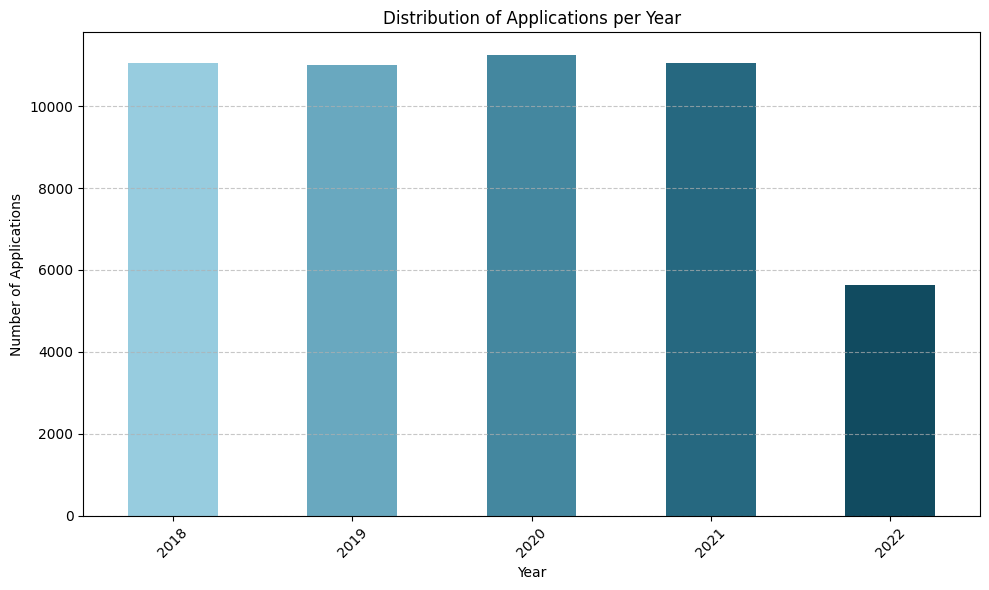

In [24]:
yearly_counts = df['ApplicationDate'].dt.year.value_counts().sort_index()

colors = ['#97CCDF', '#69A8BF', '#44879F', '#266880', '#114B60'] 

plt.figure(figsize=(10, 6))
yearly_counts.plot(kind='bar', color=colors)
plt.title('Distribution of Applications per Year')
plt.xlabel('Year')
plt.ylabel('Number of Applications')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## YOE 

This analysis seeks to understand the relationship between Years of Experience (YOE) and seniority level in the company. By calculating and graphically representing the average work experience for each level of seniority

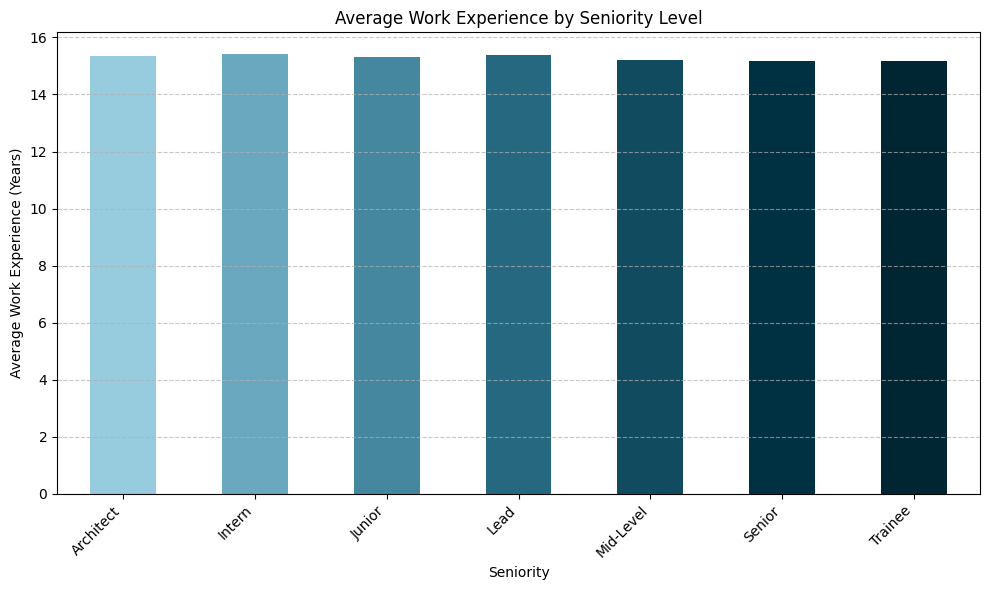

In [39]:
mean_yoe_by_seniority = df.groupby('Seniority')['YOE'].mean()

colors = ['#97CCDF', '#69A8BF', '#44879F', '#266880', '#114B60', '#003142', '#002533']

plt.figure(figsize=(10, 6))
mean_yoe_by_seniority.plot(kind='bar', color=colors)
plt.title('Average Work Experience by Seniority Level')
plt.xlabel('Seniority')
plt.ylabel('Average Work Experience (Years)')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

The discrepancy between the reported seniority levels and the average work experience found suggests that, although classified in distinct categories such as "Junior", "Mid-Level" and "Senior", the data reveal strikingly similar average work experience values in all cases, approximately 15 years.

In [40]:
mean_yoe_by_seniority = df.groupby('Seniority')['YOE'].mean()

df_table = pd.DataFrame(mean_yoe_by_seniority)
df_table.columns = ['Average YOE']  

df_table

,Average YOE
Seniority,
Architect,15.345105
Intern,15.406892
Junior,15.324930
Lead,15.365578
Mid-Level,15.213291
Senior,15.174529
Trainee,15.178616


### Country

This analysis seeks to examine the distribution of records by continent. By counting and plotting the number of records by continent, we get an overview of how our data are distributed geographically. This can provide useful information on the representativeness of our samples in different regions of the world.

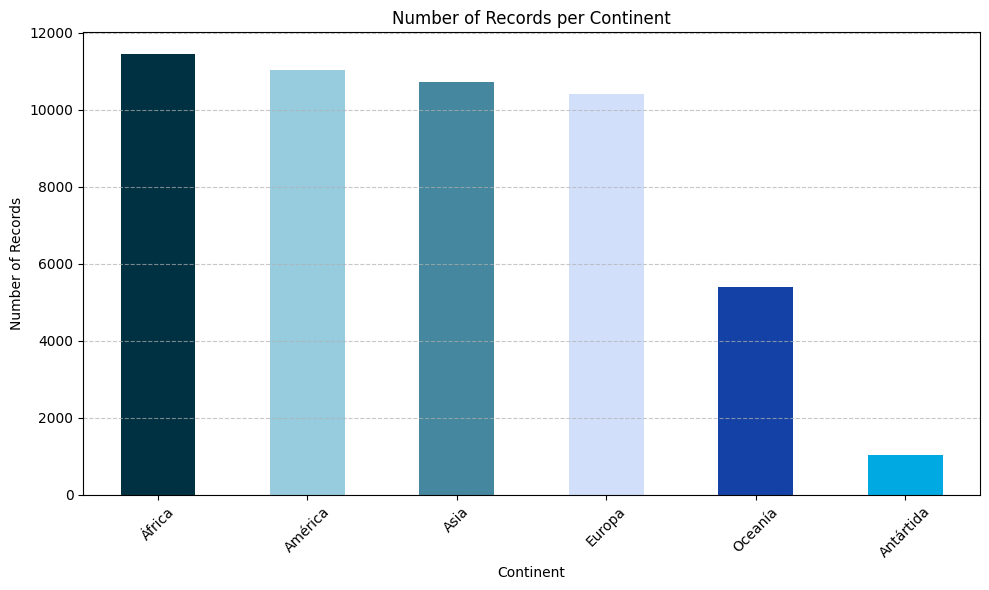

In [27]:
count_continent = df['Continent'].value_counts()

colors = ['#003142', '#97CCDF', '#44879F', '#d2dffb', '#1441a5', '#00a9e1']

plt.figure(figsize=(10, 6))
count_continent.plot(kind='bar', color=colors)
plt.title('Number of Records per Continent')
plt.xlabel('Continent')
plt.ylabel('Number of Records')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This analysis looks at the number of hires made by continent. By grouping and aggregating the number of hires by continent, we get an overview of where hires are being made around the world

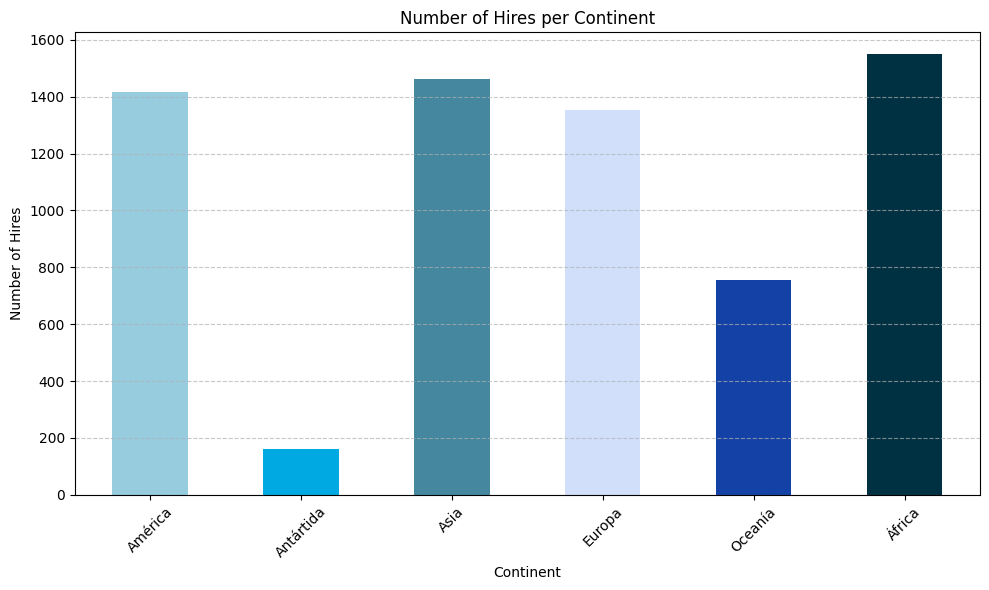

In [28]:
group_continet = df.groupby('Continent')['Hired'].sum()

colors = ['#97CCDF', '#00a9e1', '#44879F', '#d2dffb', '#1441a5', '#003142']

plt.figure(figsize=(10, 6))
group_continet.plot(kind='bar', color=colors)
plt.title('Number of Hires per Continent')
plt.xlabel('Continent')
plt.ylabel('Number of Hires')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

This analysis visualizes the number of recruitments per continent over the years.

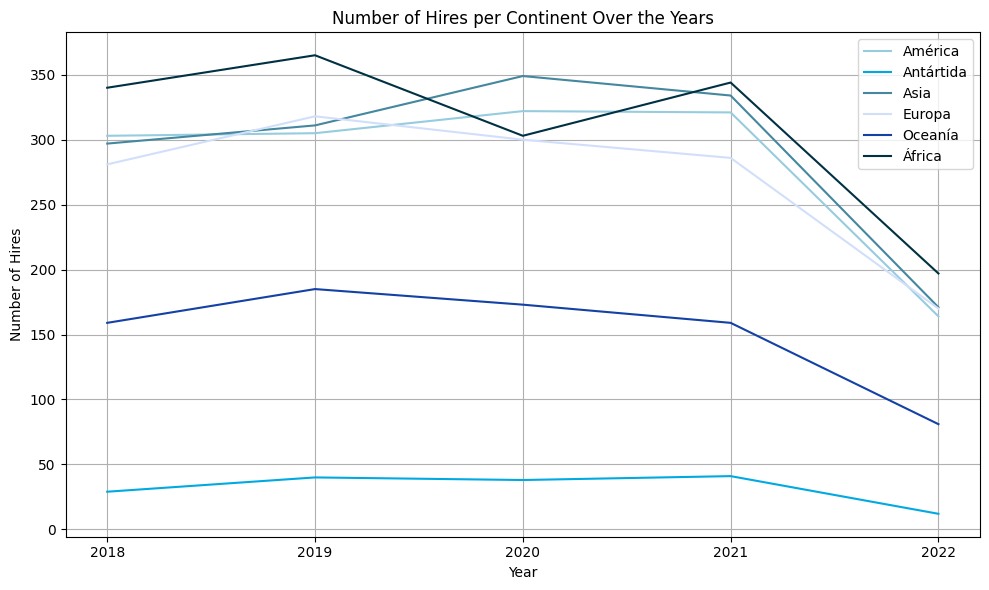

In [29]:
df['Year'] = df['ApplicationDate'].dt.year.astype(int)

df_hired = df[df['Hired'] == 1]

hired_continent = df_hired.groupby(['Year', 'Continent']).size().unstack(fill_value=0)

plt.figure(figsize=(10, 6))

colors = ['#97CCDF', '#00a9e1', '#44879F', '#d2dffb', '#1441a5', '#003142']  

for i, continent in enumerate(hired_continent.columns):
    plt.plot(hired_continent.index.astype(str), hired_continent[continent], label=continent, color=colors[i])

plt.title('Number of Hires per Continent Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Hires')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This analysis visualizes the percentage of hired versus non-hired candidates.

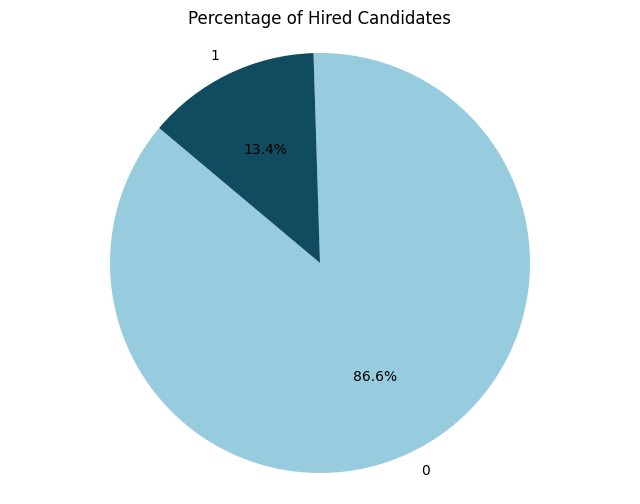

In [30]:
hired_counts = df['Hired'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(hired_counts, labels=hired_counts.index, autopct='%1.1f%%', colors=['#97CCDF','#114B60'], startangle=140)
plt.title('Percentage of Hired Candidates')
plt.axis('equal')  
plt.show()

### Hires by technology
In this section, we will examine hiring by the most in-demand technologies. We will explore how technical skills impact hiring decisions.

In [31]:
Base = declarative_base()
engine = create_engine(database_url)
Session = sessionmaker(bind=engine)
session = Session()

class CandidatesHired(Base):
    __tablename__ = 'CandidatesHired'
    id = Column(Integer, primary_key=True)
    Technology = Column(String)
    Hired = Column(Integer)


groupby_tech = session.query(CandidatesHired.Technology, func.count(CandidatesHired.Technology))\
    .filter(CandidatesHired.Hired == 1)\
    .group_by(CandidatesHired.Technology)\
    .order_by(func.count(CandidatesHired.Technology).desc())\
    .all()


table_data = [(tech, count) for tech, count in groupby_tech]


print(tabulate(table_data, headers=['Technology', 'Hired'], tablefmt='grid'))

session.close()

+-----------------------------------------+---------+
| Technology                              |   Hired |
+=========================================+=========+
| Game Development                        |     519 |
+-----------------------------------------+---------+
| DevOps                                  |     495 |
+-----------------------------------------+---------+
| System Administration                   |     293 |
+-----------------------------------------+---------+
| Development - CMS Backend               |     284 |
+-----------------------------------------+---------+
| Adobe Experience Manager                |     282 |
+-----------------------------------------+---------+
| Database Administration                 |     282 |
+-----------------------------------------+---------+
| Client Success                          |     271 |
+-----------------------------------------+---------+
| Security                                |     266 |
+---------------------------

### Chart of hires by technology 

These results suggest a high demand for skills related to game development, DevOps, system administration and web development (both backend and frontend). There is also a significant need for skills in databases, client management, IT security and content management.

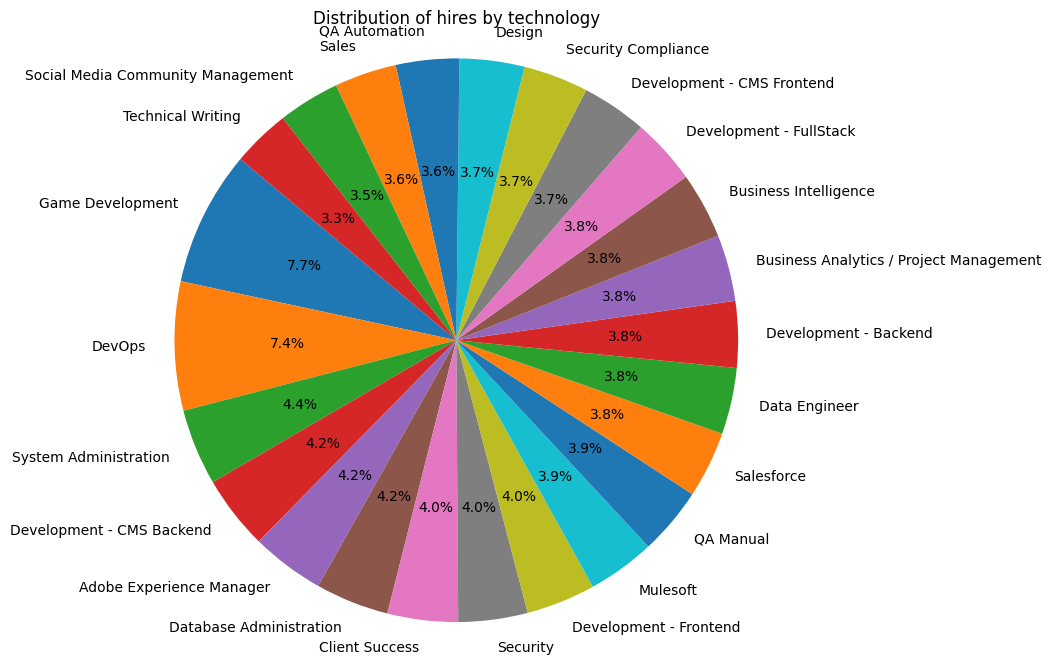

In [32]:
Technology = [row[0] for row in groupby_tech]
Hired = [row[1] for row in groupby_tech]

plt.figure(figsize=(8, 8))
plt.pie(Hired, labels=Technology, autopct='%1.1f%%', startangle=140)
plt.axis('equal') 
plt.title('Distribution of hires by technology')
plt.show()


# Categorias 

This analysis is conducted to better understand the distribution of hiring in different technology categories. It provides a quick and clear view of the most sought-after technology areas in the hiring process.

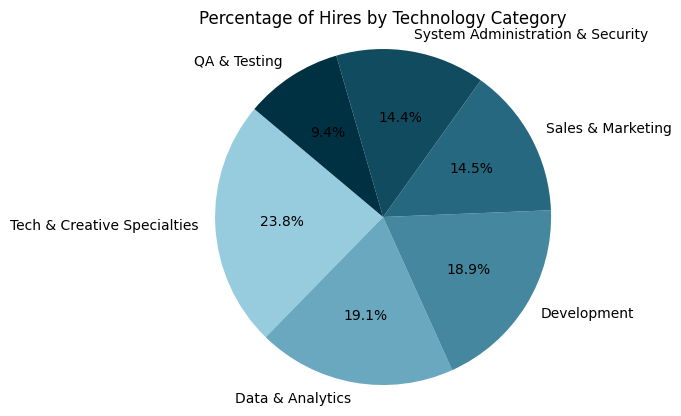

In [33]:
category_counts = df['CategoryOfTechnology'].value_counts()

labels = category_counts.index
sizes = category_counts.values

colors = ['#97CCDF', '#69A8BF', '#44879F', '#266880', '#114B60', '#003142']

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.axis('equal')  
plt.title('Percentage of Hires by Technology Category')
plt.show()

### Hires by year

We conducted a query to count the number of candidates recruited per year.

In [34]:
Base = declarative_base()
engine = create_engine(database_url)
Session = sessionmaker(bind=engine)
session = Session()


class CandidatesHired(Base):
    __tablename__ = 'CandidatesHired'
    id = Column(Integer, primary_key=True)
    ApplicationDate = Column()
    Hired = Column(Integer)

groupby_year_hired = session.query(
        extract('year', CandidatesHired.ApplicationDate).label('year'),
        CandidatesHired.Hired,
        func.count(CandidatesHired.id)
    )\
    .filter(CandidatesHired.Hired == 1)\
    .group_by('year', CandidatesHired.Hired)\
    .order_by('year')\
    .all()


data = []

for row in groupby_year_hired:
    year, hired, count = row
    data.append((year, count))


print(tabulate(data, headers=['Year', 'Count'], tablefmt='pretty'))

session.close()

+------+-------+
| Year | Count |
+------+-------+
| 2018 | 1409  |
| 2019 | 1524  |
| 2020 | 1485  |
| 2021 | 1485  |
| 2022 |  795  |
+------+-------+


#### Graph of hires per year

Analysis of the data shows a relatively stable overall hiring trend between 2018 and 2021, with numbers ranging around 1400-1500 candidates hired per year.

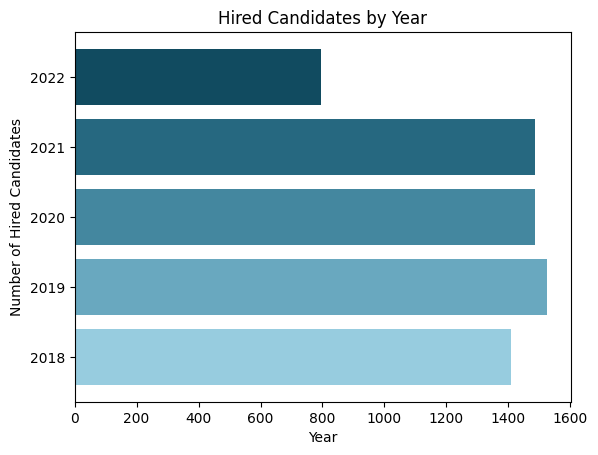

In [35]:
year = [row[0] for row in groupby_year_hired]
count = [row[2] for row in groupby_year_hired]

colors = ['#97CCDF', '#69A8BF', '#44879F', '#266880', '#114B60']  

plt.barh(year, count, color=colors)


plt.xlabel('Year')
plt.ylabel('Number of Hired Candidates')
plt.title('Hired Candidates by Year')

plt.show()

### Hires by seniority

We ran a query to obtain the count of candidates hired according to seniority category.

In [36]:
Base = declarative_base()
engine = create_engine(database_url)
Session = sessionmaker(bind=engine)
session = Session()

class CandidatesHired(Base):
    __tablename__ = 'CandidatesHired'
    id = Column(Integer, primary_key=True)
    Seniority = Column(String)
    Hired = Column(Integer)


groupby_seniority = session.query(CandidatesHired.Seniority, func.count(CandidatesHired.Seniority))\
    .filter(CandidatesHired.Hired == 1)\
    .group_by(CandidatesHired.Seniority)\
    .order_by(func.count(CandidatesHired.Seniority).desc())\
    .all()


table_data = [(tech, count) for tech, count in groupby_seniority]


print(tabulate(table_data, headers=['Seniority', 'Hired'], tablefmt='grid'))

session.close()

+-------------+---------+
| Seniority   |   Hired |
+=============+=========+
| Intern      |     985 |
+-------------+---------+
| Junior      |     977 |
+-------------+---------+
| Trainee     |     973 |
+-------------+---------+
| Architect   |     971 |
+-------------+---------+
| Senior      |     939 |
+-------------+---------+
| Lead        |     929 |
+-------------+---------+
| Mid-Level   |     924 |
+-------------+---------+


#### Graph of hires by seniority

The analysis of hires by seniority level reveals a balanced distribution of candidates hired at different levels of experience.

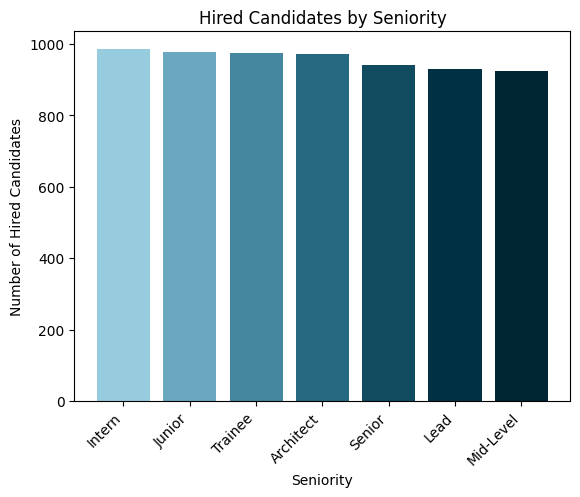

In [37]:
seniorities = [row[0] for row in groupby_seniority]
counts = [row[1] for row in groupby_seniority]

colors = ['#97CCDF', '#69A8BF', '#44879F', '#266880', '#114B60', '#003142', '#002533']

plt.bar(seniorities, counts, color=colors)
plt.xlabel('Seniority')
plt.ylabel('Number of Hired Candidates')
plt.title('Hired Candidates by Seniority')
plt.xticks(rotation=45, ha='right')
plt.show()


### Hires by country over years

We ran a query to obtain the count of candidates hired by year and country.

In [38]:
Base = declarative_base()
engine = create_engine(database_url)
Session = sessionmaker(bind=engine)
session = Session()


class CandidatesHired(Base):
    __tablename__ = 'CandidatesHired'
    id = Column(Integer, primary_key=True)
    ApplicationDate = Column()
    Country = Column(String)
    Hired = Column(Integer)

paises_interes = ['United States of America', 'Brazil', 'Colombia', 'Ecuador']


groupby_country_year = session.query(
        CandidatesHired.Country,
        extract('year', CandidatesHired.ApplicationDate).label('year'),
        func.count(CandidatesHired.id)
    )\
    .filter(CandidatesHired.Hired == 1)\
    .filter(CandidatesHired.Country.in_(paises_interes))\
    .group_by(CandidatesHired.Country, 'year')\
    .order_by('year')\
    .all()

data = []
for row in groupby_country_year:
    country, year, count = row
    data.append((country, year, count))


print(tabulate(data, headers=['Country', 'Year', 'Hired Candidates'], tablefmt='pretty'))

session.close()

+--------------------------+------+------------------+
|         Country          | Year | Hired Candidates |
+--------------------------+------+------------------+
|          Brazil          | 2018 |        9         |
|         Colombia         | 2018 |        7         |
|         Ecuador          | 2018 |        1         |
| United States of America | 2018 |        5         |
|          Brazil          | 2019 |        7         |
|         Colombia         | 2019 |        8         |
|         Ecuador          | 2019 |        3         |
| United States of America | 2019 |        3         |
|          Brazil          | 2020 |        6         |
|         Colombia         | 2020 |        8         |
|         Ecuador          | 2020 |        8         |
| United States of America | 2020 |        4         |
|          Brazil          | 2021 |        7         |
|         Colombia         | 2021 |        1         |
|         Ecuador          | 2021 |        5         |
| United S